In [1]:
import torch
from torch.nn.functional import grid_sample
from math import log,ceil,pi
import matplotlib.pyplot as plt
import my_bspline as mbs
import vector_field_to_flow as vff

%load_ext autoreload
%autoreload 2
import my_torchbox as tb
plt.rcParams['figure.figsize'] = [10,10]

This part is about field integration using Lagrangian schemes

# Introduction

Before giving the usage of the functions in $\texttt{vector\_field\_to\_flow}$ lets explain the
key part of the algorithm. How to compose vector fields to deformations


We start by opening everything we need and show $\mathrm{Id}$ along with $v$:

/home/turtlefox/Documents/Doctorat/Demeter/my_torchbox.py:789: DeprecationWarning: Call to deprecated function gridDef_plot (Please specify the dimension by using gridDef_plot_2d ot gridDef_plot_3d).
  gridDef_plot(field + regular_grid,step=step,ax = axes[0],


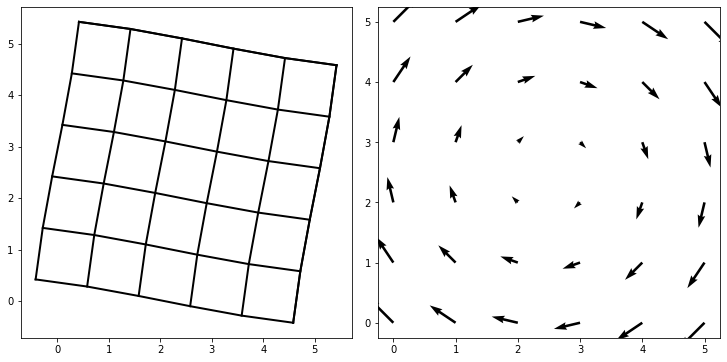

In [2]:
H,W = (6,6)

xx, yy = torch.meshgrid(torch.linspace(-1, 1, W), torch.linspace(-1, 1, H))

r = .5
v = torch.stack((r*torch.sin(xx),r*torch.cos(yy+pi/2)),dim=2).unsqueeze(0)
tb.vectField_show(v,step=1)



A plot function to show composition.

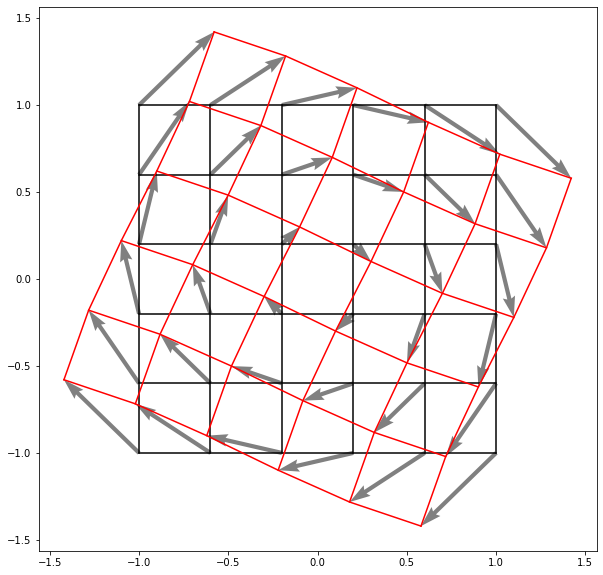

In [3]:
def show_grid_composition(grid,vector_field):
    deformed_grid = grid + vector_field
    plt.figure()
    # plot initial grid
    plt.plot(grid[0,...,0],grid[0,...,1],color='black')
    plt.plot(grid[0,...,0].T,grid[0,...,1].T,color='black')

    plt.plot(deformed_grid[0,...,0],deformed_grid[0,...,1],color='red')
    plt.plot(deformed_grid[0,...,0].T,deformed_grid[0,...,1].T,color='red')

    # plt.plot([grid[0,...,0].flatten().numpy(),deformed_grid[0,...,0].flatten().numpy()],
    #          [grid[0,...,1].flatten().numpy(),deformed_grid[0,...,1].flatten().numpy()]
    #          ,color='gray')
    plt.quiver(grid[0,...,0].flatten().numpy(),
               grid[0,...,1].flatten().numpy(),
               deformed_grid[0,...,0].flatten().numpy() - grid[0,...,0].flatten().numpy(),
               deformed_grid[0,...,1].flatten().numpy() - grid[0,...,1].flatten().numpy(),
               color ='gray',
               angles='xy', scale_units='xy', scale=1
               )

    return deformed_grid

regular_grid = torch.stack((xx.T,yy.T),dim=2).unsqueeze(0)
v_grid = show_grid_composition(regular_grid,v)

In [4]:
# because grid_sample is built for image interpolation
# or deformation we need to change the coordinate system
# i.e. : pass from grid coordinate from image coordinate system
v_as_image = tb.grid2im(v)

# interpolation on v_grid (v_grid = regular_grid + v)
v_on_v_grid = grid_sample(v_as_image,v_grid)

# pass from image coordinate to grid coordinate
v_on_v_grid = tb.im2grid(v_on_v_grid)

/home/turtlefox/anaconda3/envs/gliomorph_env/lib/python3.8/site-packages/torch/nn/functional.py:3981: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


The next figure show the operation, the gray arrows are the initial vector field $v$
on a regular grid $x$. The blues crosses are the particules of the regular grid deformed.
Finally the re arrows represent $v$ on the deformed grid.

note that outside the dashed scare, the field is padded to zero by the interpolation

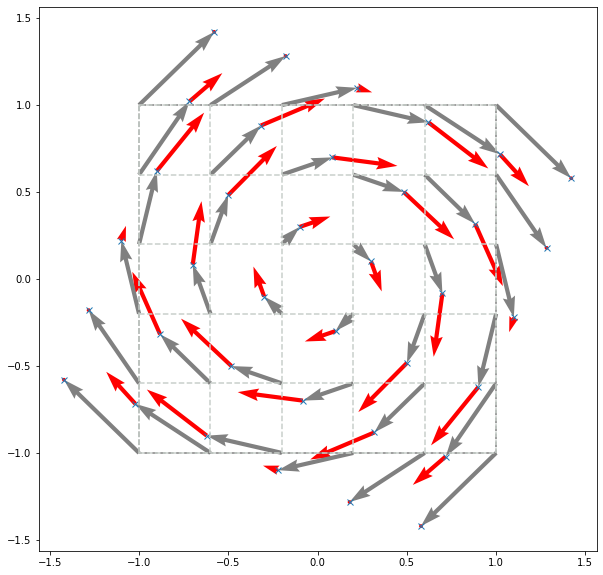

In [5]:
fig, ax = plt.subplots()
ax.plot(v_grid[0,:,:,0].flatten().numpy(),v_grid[0,:,:,1].flatten().numpy(),'x')
ax.quiver(v_grid[0,:,:,0].flatten().numpy(),
           v_grid[0,:,:,1].flatten().numpy(),
           v_on_v_grid[0,:,:,0].flatten().numpy(),
           v_on_v_grid[0,:,:,1].flatten().numpy(),
           color='red',
           angles='xy', scale_units='xy', scale=1)

ax.quiver(xx.T,yy.T,v[0,:,:,0],v[0,:,:,1],color = 'gray',
            angles='xy', scale_units='xy', scale=1)
ax.plot([-1,-1,1,1,-1],[-1,1,1,-1,-1],'--',color='gray')
ax.plot(xx,yy,'--',color=[200.0/255, 207.0/255, 202.0/255])
ax.plot(xx.T,yy.T,'--',color=[200.0/255, 207.0/255, 202.0/255])
# v2_grid =show_grid_composition(v_grid,v_on_v_grid)
# tb.showDef(v_on_v_grid,step=1)

Now we can compute the new vector field $w$ defined such that  $\mathrm{Id} + w = v \circ (\mathrm{Id} +v) $

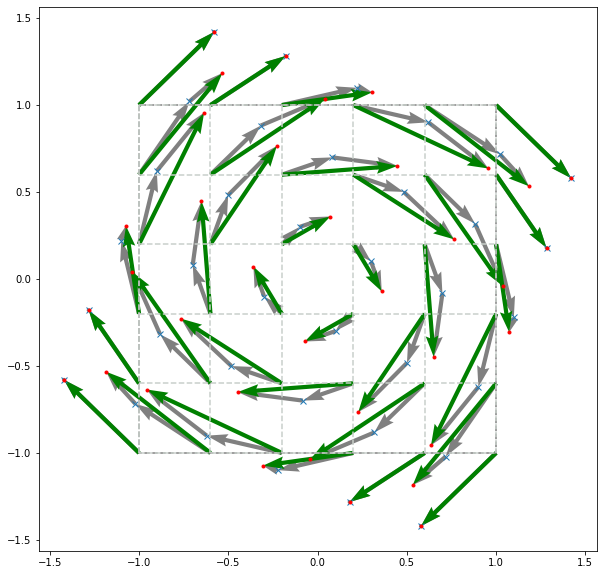

In [6]:
# fields composition
vcv = v + v_on_v_grid

# vizualisation
fig_2, ax_2 = plt.subplots()
ax_2.plot(v_grid[0,:,:,0].flatten().numpy(),v_grid[0,:,:,1].flatten().numpy(),'x')
ax_2.quiver(v_grid[0,:,:,0].flatten().numpy().T,
           v_grid[0,:,:,1].flatten().numpy().T,
           v_on_v_grid[0,:,:,0].flatten().numpy(),
           v_on_v_grid[0,:,:,1].flatten().numpy(),
           color='gray',
           angles='xy', scale_units='xy', scale=1)

ax_2.quiver(xx.T,yy.T,v[0,:,:,0],v[0,:,:,1],color = 'gray',
            angles='xy', scale_units='xy', scale=1)
ax_2.plot(regular_grid[0,:,:,0].flatten() + vcv[0,:,:,0].flatten().numpy(),
          regular_grid[0,:,:,1].flatten() + vcv[0,:,:,1].flatten().numpy(),'.r')
ax_2.plot([-1,-1,1,1,-1],[-1,1,1,-1,-1],'--',color='gray')

ax_2.plot(xx,yy,'--',color=[200.0/255, 207.0/255, 202.0/255])
ax_2.plot(xx.T,yy.T,'--',color=[200.0/255, 207.0/255, 202.0/255])
ax_2.quiver(xx.T,yy.T,vcv[0,:,:,0],vcv[0,:,:,1],color = 'green',
            angles='xy', scale_units='xy', scale=1)

If we would like to interpolate $v$ on the grid deformed by $w$ we would need to interpolate
like so
$\texttt{grid_sample}(v,x +w)$

/home/turtlefox/anaconda3/envs/gliomorph_env/lib/python3.8/site-packages/torch/nn/functional.py:3981: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


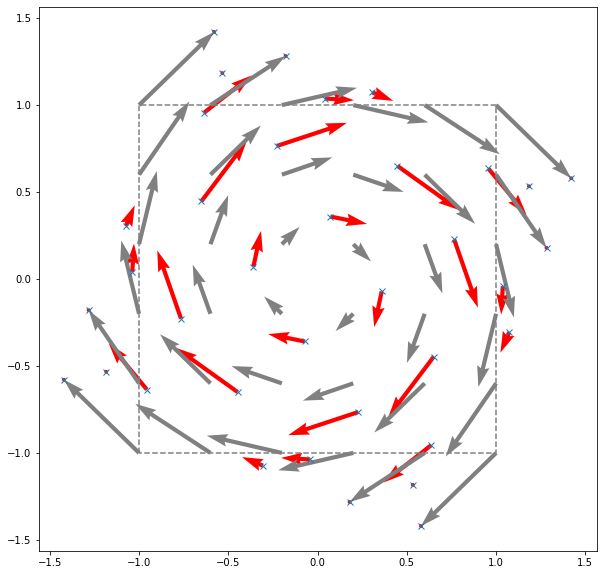

In [7]:
v_as_image = tb.grid2im(v)
w_on_grid = regular_grid + vcv
# interpolation on v_grid
v_on_w_grid = grid_sample(v_as_image,w_on_grid)

# pass from image coordinate to grid coordinate
v_on_w_grid = tb.im2grid(v_on_w_grid)

#
fig, ax = plt.subplots()
ax.plot(w_on_grid[0,:,:,0].flatten().numpy(),w_on_grid[0,:,:,1].flatten().numpy(),'x')
ax.quiver(w_on_grid[0,:,:,0].flatten().numpy(),
           w_on_grid[0,:,:,1].flatten().numpy(),
           v_on_w_grid[0,:,:,0].flatten().numpy(),
           v_on_w_grid[0,:,:,1].flatten().numpy(),
           color='red',
           angles='xy', scale_units='xy', scale=1)

ax.quiver(xx.T,yy.T,v[0,:,:,0],v[0,:,:,1],color = 'gray',
            angles='xy', scale_units='xy', scale=1)
ax.plot([-1,-1,1,1,-1],[-1,1,1,-1,-1],'--',color='gray')


If we recapitulate compute $v_2$ which is defined as :
\begin{align}
&\varphi_0 = Id + v\\
&\varphi_1 = \varphi_0 \circ  \varphi_0\\
&\varphi_2 = \varphi_1 \circ \varphi_0
\end{align}

we do

\begin{align}
&v_0 = x +v \\
&v_1 = v + \texttt{grid_sample}(v,x + v)\\
&v_2 = v_1 + \texttt{grid_sample}(v,x +v_1)
\end{align}

## Fast exponential
\begin{align}
&N = \mathrm{opti}(v)\\
&\text{Compute a first approximation of } \phi_0 \leftarrow \exp(2^{-N}v) \approx Id + 2^{-N}v \\
&\text{For } k \text{ from } 1 \text{ to } N\\
&\qquad	\phi_k \leftarrow \phi_{k-1} \circ \phi_{k-1}
\end{align}

so in practice we do:
\begin{align}
&v_0 =  v/2^N \\
&v_1 = v/2^N + \texttt{grid_sample}(v/2^N,x + v/2^N)\\
&v_2 = v_1 + \texttt{grid_sample}(v_1,x +v_1)
\end{align}

## Computing the inverse of a temporal field

Let say we have a temporal vector field $v_t$ and we want to generate the inverse flow
### First step : invese vector field

Given a vector field $v$ we need to find the vector field which associate $ Id + v$ to $Id$ and
interpolate it on a regular grid.

Pour une raison que je ne comprend pas vraiment, si je ne n'applique pas $\mathrm{exp}( v)$ au
images. Elle ont un comportement étrange. Du coup je travaille avec ça.


Let's make a vector field

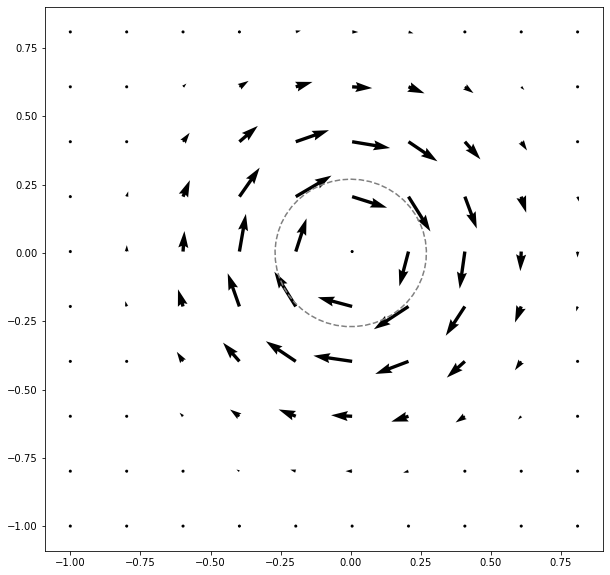

In [8]:

dx_convention = '2square'
H,W = (200,200)
step = 20
id_grid = tb.make_regular_grid((1,H,W,2),dx_convention=dx_convention)

# construction du champ de vecteur
coef_mat = 0.8*torch.exp(-5*(id_grid[0,...,0]**2 +id_grid[0,...,1]**2)).unsqueeze(-1)
v = coef_mat*torch.stack((torch.sin(id_grid[0,...,1]),
                             torch.cos(id_grid[0,...,0]+pi/2)),dim=2).unsqueeze(0)

fastexp_integrator = vff.FieldIntegrator(method='fast_exp',save=False,
                                         dx_convention=dx_convention)
exp_v = fastexp_integrator(v.clone(),forward=True)

tb.quiver_plot(exp_v.clone() - id_grid,step=step,
               dx_convention=dx_convention,real_scale=True)

x = torch.linspace(0,2*pi,50)
rond = .27*torch.stack((torch.sin(x),torch.cos(x)),dim=0)
plt.plot(rond[0],rond[1],'--',color='gray')
# cms = mbs.getCMS_turn()
# v = mbs.field2D_bspline(cms,(H,W),dim_stack=2).unsqueeze(0)/5
# tb.vectField_show(v,step = 20)

For a single vector field
$$v^{-1} \sim -v \circ (Id +v)$$

/home/turtlefox/anaconda3/envs/gliomorph_env/lib/python3.8/site-packages/torch/nn/functional.py:3981: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


<AxesSubplot:>

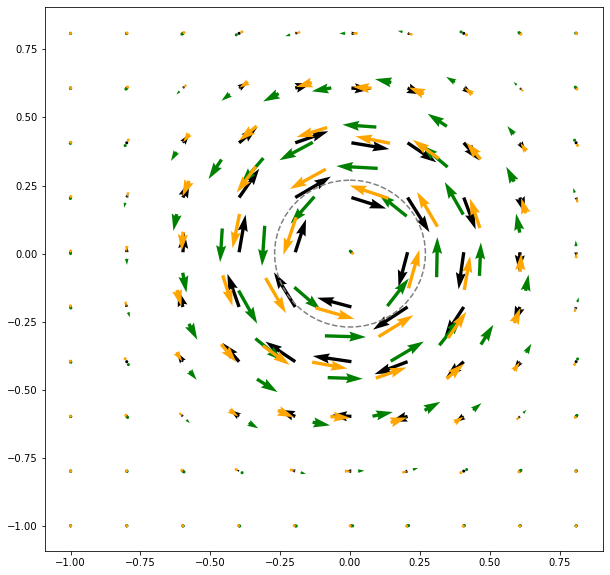

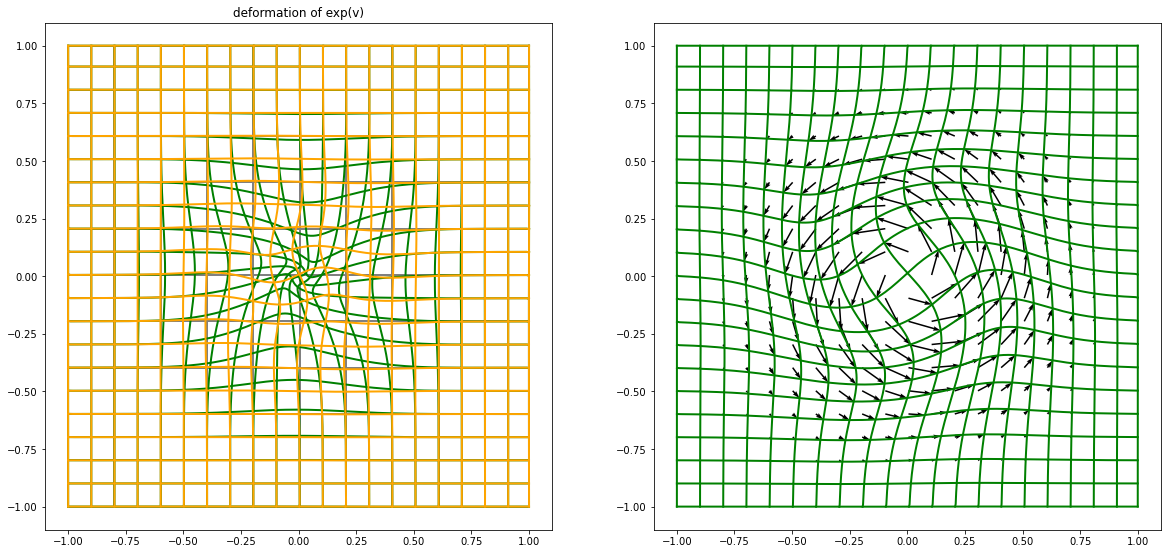

In [9]:
# compute the 'inverse' vector field
inv_v_m = tb.im2grid(grid_sample(tb.grid2im(-v),id_grid-v))
exp_inv_v_m = fastexp_integrator(inv_v_m,forward=True)

inv_v_p = tb.im2grid(grid_sample(tb.grid2im(-v),id_grid+v))
exp_inv_v_p = fastexp_integrator(inv_v_p,forward=True)

# visualisation
plt.rcParams['figure.figsize'] = [10,10]
fig,ax= plt.subplots()

tb.quiver_plot(exp_v.clone() - id_grid,step=step,ax=ax,
               dx_convention=dx_convention)
ax.quiver(id_grid[0,::step,::step,0]-v[0,::step,::step,0],
             id_grid[0,::step,::step,1]-v[0,::step,::step,1],
             (exp_inv_v_m - id_grid)[0,::step,::step,0],
             (exp_inv_v_m - id_grid)[0,::step,::step,1],
             scale_units='xy', scale=1,
             color='green'
             )
ax.quiver(id_grid[0,::step,::step,0]+v[0,::step,::step,0],
             id_grid[0,::step,::step,1]+v[0,::step,::step,1],
             (exp_inv_v_p - id_grid)[0,::step,::step,0],
             (exp_inv_v_p - id_grid)[0,::step,::step,1],
             scale_units='xy', scale=1,
             color='orange')
# tb.quiver_plot(exp_inv_v_p-id_grid,step=step,ax=ax[0],color='orange')
ax.plot(rond[0],rond[1],'--',color='gray')

fig,ax= plt.subplots(1,2,figsize = (20,10))
tb.gridDef_plot_2d(id_grid,step=step,ax=ax[0],color='gray')
tb.gridDef_plot_2d(exp_v + exp_inv_v_m- id_grid,add_grid=False,step=10,ax=ax[0]
                ,title='deformation of exp(v)',color='green')
tb.gridDef_plot_2d(exp_v + exp_inv_v_p - id_grid,add_grid=False,step=10,ax=ax[0]
                ,title='deformation of exp(v)',color='orange')

# tb.gridDef_plot(exp_v,step=10,ax=ax[1],title='deformation of exp(v)')

tb.quiver_plot(exp_inv_v_p-id_grid,step=10,ax=ax[1],
               title='inverse deformation of exp(v)',
               dx_convention=dx_convention)
tb.gridDef_plot_2d(exp_inv_v_p,step=10,ax=ax[1],color='green',dx_convention=dx_convention)


Let's test it on images

/home/turtlefox/anaconda3/envs/gliomorph_env/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


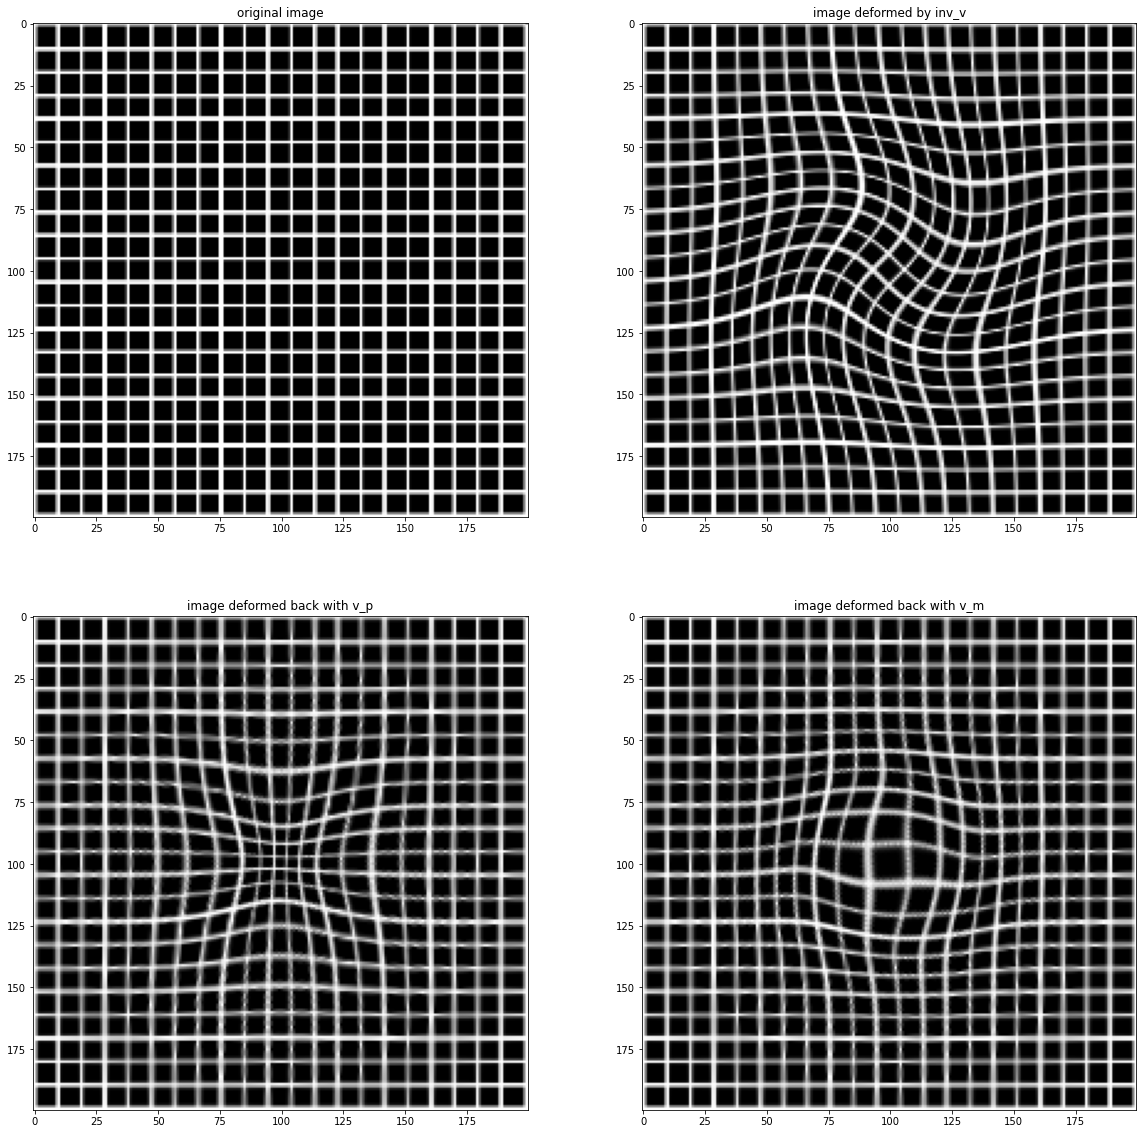

tensor(0.1773)
tensor(0.1795)


In [10]:
I = tb.reg_open('grid',size=(H,W))
I_v = tb.imgDeform(I,exp_v)
# I_v = grid_sample(I,exp_v)
I_v_mv_p = tb.imgDeform(I_v,exp_inv_v_p)
I_v_mv_m = tb.imgDeform(I_v,exp_inv_v_m)


plt.rcParams['figure.figsize'] = [20,20]
# plt.rcParams['figure.figsize'] = [30,10]
fig, axes = plt.subplots(2,2)
axes[0,0].set_title('original image')
axes[0,0].imshow(I[0,0,:,:],cmap='gray')

axes[0,1].set_title('image deformed by inv_v')
axes[0,1].imshow(I_v[0,0,:,:],cmap='gray')

axes[1,0].set_title('image deformed back with v_p')
axes[1,0].imshow(I_v_mv_p[0,0,:,:],cmap='gray')

axes[1,1].set_title('image deformed back with v_m')
axes[1,1].imshow(I_v_mv_m[0,0,:,:],cmap='gray')
plt.show()

print(torch.abs(I- I_v_mv_p).sum()/(H*W))
print(torch.abs(I- I_v_mv_m).sum()/(H*W))

The recovered image is not a perfect identity grid. Indeed in this
inverse computation method we do a lot of approximations, and therefore are valid for vector fields small enough. In practice we will compose only small vector fields, so the method seems legit.

## Step two : Integrating backward a temporal vector field.

let's make a temporal vector field first

/tmp/ipykernel_73132/2741120763.py:33: DeprecationWarning: Call to deprecated function gridDef_plot (Please specify the dimension by using gridDef_plot_2d ot gridDef_plot_3d).
  tb.gridDef_plot(exp_v_t[t].unsqueeze(0),add_grid=True,step=10,ax=ax[t],
/tmp/ipykernel_73132/2741120763.py:33: DeprecationWarning: Call to deprecated function gridDef_plot (Please specify the dimension by using gridDef_plot_2d ot gridDef_plot_3d).
  tb.gridDef_plot(exp_v_t[t].unsqueeze(0),add_grid=True,step=10,ax=ax[t],
/tmp/ipykernel_73132/2741120763.py:33: DeprecationWarning: Call to deprecated function gridDef_plot (Please specify the dimension by using gridDef_plot_2d ot gridDef_plot_3d).
  tb.gridDef_plot(exp_v_t[t].unsqueeze(0),add_grid=True,step=10,ax=ax[t],


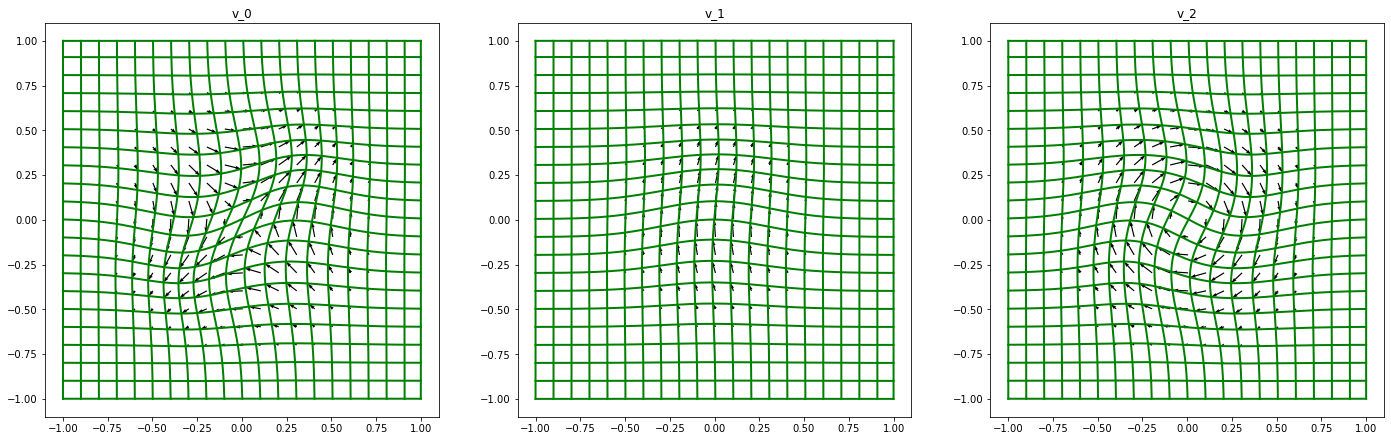

In [11]:
import torch
from torch.nn.functional import grid_sample
from math import log,ceil,pi
import matplotlib.pyplot as plt

import my_torchbox as tb
import vector_field_to_flow as vff
plt.rcParams['figure.figsize'] = [24,8]

Tau,H,W = (3,200,200)
dx_convention = '2square'
id_grid = tb.make_regular_grid((1,H,W,2),dx_convention=dx_convention)

fastexp_integrator = vff.FieldIntegrator(method='fast_exp',save=False,
                                         dx_convention=dx_convention)


r = [.5,.1,.5]
y_mod = torch.linspace(-pi/2,pi/2,Tau)
v_t = torch.zeros((Tau,H,W,2))
exp_v_t = torch.zeros(v_t.shape)
coef_mat = torch.exp(-5*(id_grid[0,...,0]**2 +id_grid[0,...,1]**2)).unsqueeze(-1)

fig,ax = plt.subplots(1,3)
for t in range(Tau):

    v_t[t,:,:,:] = r[t] *(coef_mat*torch.stack((torch.sin(id_grid[0,...,1]),
                             torch.cos(id_grid[0,...,0]+y_mod[t])),dim=2)).unsqueeze(0)

    exp_v_t[t] = fastexp_integrator(v_t[t].unsqueeze(0).clone()) -id_grid
    tb.quiver_plot(exp_v_t[t].unsqueeze(0) ,step=10,ax=ax[t],
                   dx_convention=dx_convention)
    tb.gridDef_plot(exp_v_t[t].unsqueeze(0),add_grid=True,step=10,ax=ax[t],
                    color='green',dx_convention=dx_convention)
    ax[t].set_title(f"v_{t}")

let's check the result of a forward pass. By passing the argument `save` to `True`
we get the cumulated transformation.

/tmp/ipykernel_73132/2393894175.py:9: DeprecationWarning: Call to deprecated function gridDef_plot (Please specify the dimension by using gridDef_plot_2d ot gridDef_plot_3d).
  tb.gridDef_plot(int_exp_v_t[i].unsqueeze(0),add_grid=False,step=10,ax=ax[i],
/tmp/ipykernel_73132/2393894175.py:9: DeprecationWarning: Call to deprecated function gridDef_plot (Please specify the dimension by using gridDef_plot_2d ot gridDef_plot_3d).
  tb.gridDef_plot(int_exp_v_t[i].unsqueeze(0),add_grid=False,step=10,ax=ax[i],
/tmp/ipykernel_73132/2393894175.py:9: DeprecationWarning: Call to deprecated function gridDef_plot (Please specify the dimension by using gridDef_plot_2d ot gridDef_plot_3d).
  tb.gridDef_plot(int_exp_v_t[i].unsqueeze(0),add_grid=False,step=10,ax=ax[i],


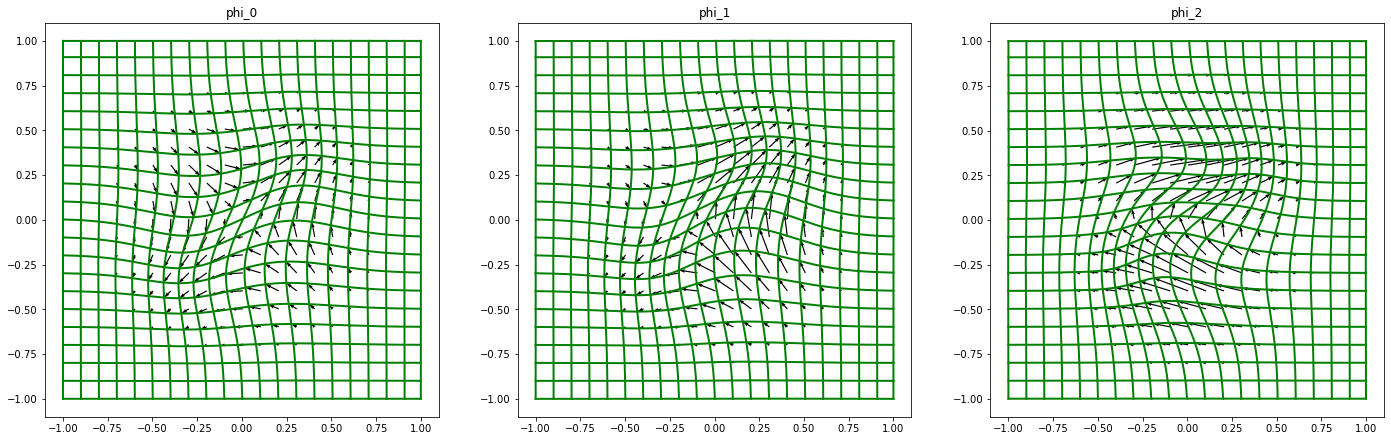

In [12]:
temporal_integrator = vff.FieldIntegrator(method='temporal',save='True',
                                          dx_convention=dx_convention)
int_exp_v_t = temporal_integrator(exp_v_t,forward=True)

fig,ax = plt.subplots(1,3)
for i in range(Tau):
    tb.quiver_plot(int_exp_v_t[i].unsqueeze(0) - id_grid ,step=10,ax=ax[i],
                   dx_convention=dx_convention)
    tb.gridDef_plot(int_exp_v_t[i].unsqueeze(0),add_grid=False,step=10,ax=ax[i],
                    color='green',dx_convention=dx_convention)
    ax[i].set_title(f"phi_{i}")

Lets loop the step one and compose it with the forward pass. which can be done easily using the
function of the forward pass.

/tmp/ipykernel_73132/1850195869.py:9: DeprecationWarning: Call to deprecated function gridDef_plot (Please specify the dimension by using gridDef_plot_2d ot gridDef_plot_3d).
  tb.gridDef_plot(int_rev_exp_v_t[i].unsqueeze(0),add_grid=False,step=10,ax=ax[i],
/tmp/ipykernel_73132/1850195869.py:9: DeprecationWarning: Call to deprecated function gridDef_plot (Please specify the dimension by using gridDef_plot_2d ot gridDef_plot_3d).
  tb.gridDef_plot(int_rev_exp_v_t[i].unsqueeze(0),add_grid=False,step=10,ax=ax[i],
/tmp/ipykernel_73132/1850195869.py:9: DeprecationWarning: Call to deprecated function gridDef_plot (Please specify the dimension by using gridDef_plot_2d ot gridDef_plot_3d).
  tb.gridDef_plot(int_rev_exp_v_t[i].unsqueeze(0),add_grid=False,step=10,ax=ax[i],


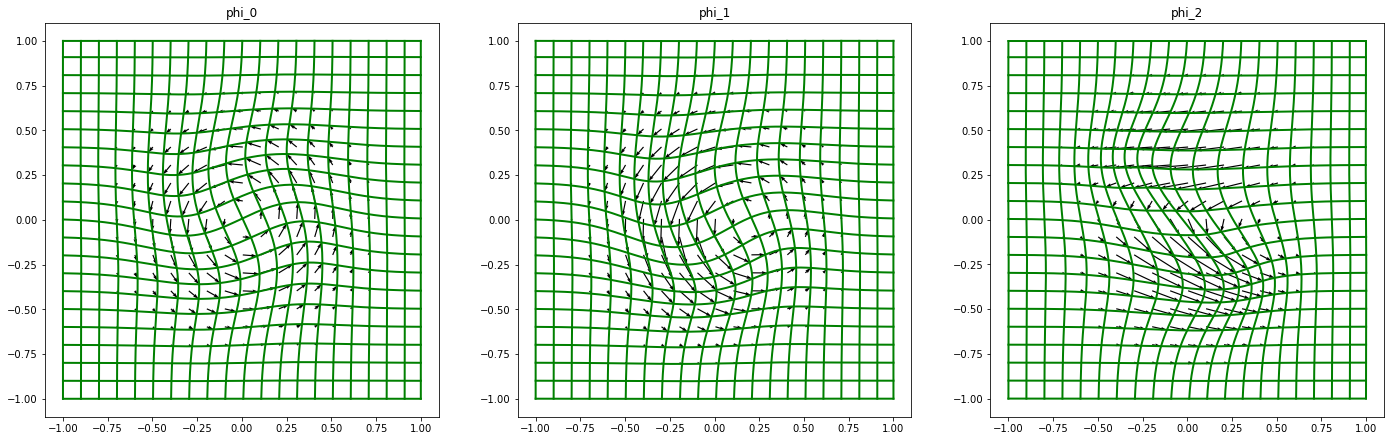

In [13]:
# THIS is the important line
int_rev_exp_v_t = temporal_integrator(-exp_v_t.flip(0))


fig,ax = plt.subplots(1,3)
for i in range(Tau):
    tb.quiver_plot(int_rev_exp_v_t[i].unsqueeze(0) - id_grid ,step=10,ax=ax[i],
                   dx_convention=dx_convention)
    tb.gridDef_plot(int_rev_exp_v_t[i].unsqueeze(0),add_grid=False,step=10,ax=ax[i],
                    dx_convention=dx_convention,color='green')
    ax[i].set_title(f"phi_{i}")

Let's compose the two flows checking if we have identity deformation

/home/turtlefox/anaconda3/envs/gliomorph_env/lib/python3.8/site-packages/torch/nn/functional.py:3981: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/tmp/ipykernel_73132/1505608676.py:11: DeprecationWarning: Call to deprecated function gridDef_plot (Please specify the dimension by using gridDef_plot_2d ot gridDef_plot_3d).
  tb.gridDef_plot(int_rev_exp_v_t[-1].unsqueeze(0),add_grid=False,step=10,ax=ax[0],
/tmp/ipykernel_73132/1505608676.py:17: DeprecationWarning: Call to deprecated function gridDef_plot (Please specify the dimension by using gridDef_plot_2d ot gridDef_plot_3d).
  tb.gridDef_plot(int_exp_v_t[-1].unsqueeze(0)+int_rev_exp_v_t_on_int_exp_v_t ,


<AxesSubplot:>

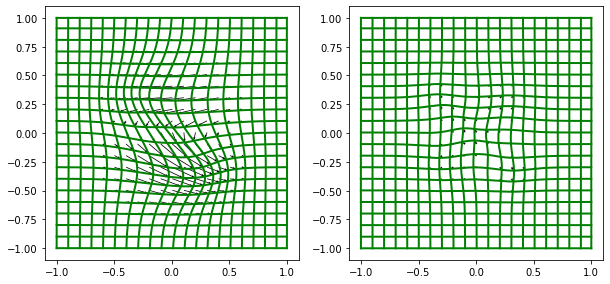

In [14]:
# compose the two vector fields
int_rev_exp_v_t_on_int_exp_v_t = grid_sample(tb.grid2im(int_rev_exp_v_t[-1].unsqueeze(0) -id_grid),
                                             int_exp_v_t[-1].unsqueeze(0))
int_rev_exp_v_t_on_int_exp_v_t = tb.im2grid(int_rev_exp_v_t_on_int_exp_v_t)



fig,ax = plt.subplots(1,2,figsize=(10,5))
tb.quiver_plot(int_rev_exp_v_t[-1].unsqueeze(0) - id_grid ,step=10,ax=ax[0],
               dx_convention=dx_convention)
tb.gridDef_plot(int_rev_exp_v_t[-1].unsqueeze(0),add_grid=False,step=10,ax=ax[0],
                dx_convention=dx_convention,color='green')


tb.quiver_plot(int_exp_v_t[-1].unsqueeze(0)+int_rev_exp_v_t_on_int_exp_v_t-id_grid,
               step=10,ax=ax[1],dx_convention=dx_convention)
tb.gridDef_plot(int_exp_v_t[-1].unsqueeze(0)+int_rev_exp_v_t_on_int_exp_v_t ,
                add_grid=False,step=10,ax=ax[1],color='green',dx_convention=dx_convention)



________
________
# Documentation


/home/turtlefox/Documents/Doctorat/Demeter/my_torchbox.py:789: DeprecationWarning: Call to deprecated function gridDef_plot (Please specify the dimension by using gridDef_plot_2d ot gridDef_plot_3d).
  gridDef_plot(field + regular_grid,step=step,ax = axes[0],


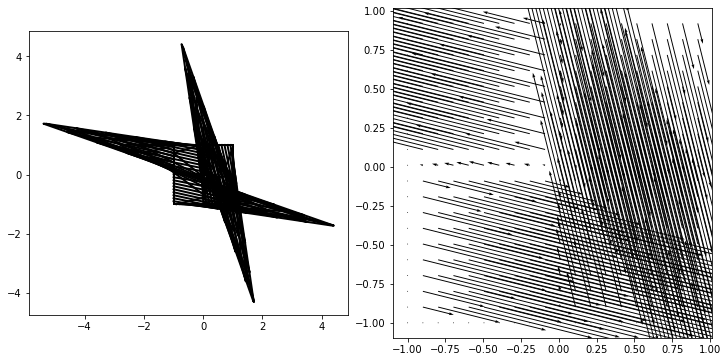

In [15]:
import time as t
plt.rcParams['figure.figsize'] = [16,8]

H,W = (100,100)
dx_convention ='2square'
cms = mbs.getCMS_turn()

# vector field generation
v = mbs.field2D_bspline(cms,(H,W),dim_stack=2).unsqueeze(0)*5

id_grid = tb.make_regular_grid(v.shape,dx_convention=dx_convention)

# xx, yy = torch.meshgrid(torch.linspace(-1, 1, W), torch.linspace(-1, 1, H))
tb.vectField_show(v,step=5,dx_convention=dx_convention)
# tb.showDef(v,grid =(xx,yy),step = 5)


Usage of $\texttt{FieldIntegrator}$: for the exponential map.

N =  12 => n_step =  4096
fast exp executed in  0.002923250198364258  s
N =  12 => n_step =  4096
slow exp executed in  0.7425262928009033  s
norm 1 of the difference given by the two method =  tensor(0.0003)


/tmp/ipykernel_73132/2084941757.py:14: DeprecationWarning: Call to deprecated function gridDef_plot (Please specify the dimension by using gridDef_plot_2d ot gridDef_plot_3d).
  tb.gridDef_plot(exp_v_fast,ax=ax1,step=5,color='green',check_diffeo=False)
/tmp/ipykernel_73132/2084941757.py:17: DeprecationWarning: Call to deprecated function gridDef_plot (Please specify the dimension by using gridDef_plot_2d ot gridDef_plot_3d).
  tb.gridDef_plot(exp_v_slow,ax=ax1,step=5,color='orange')
/tmp/ipykernel_73132/2084941757.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


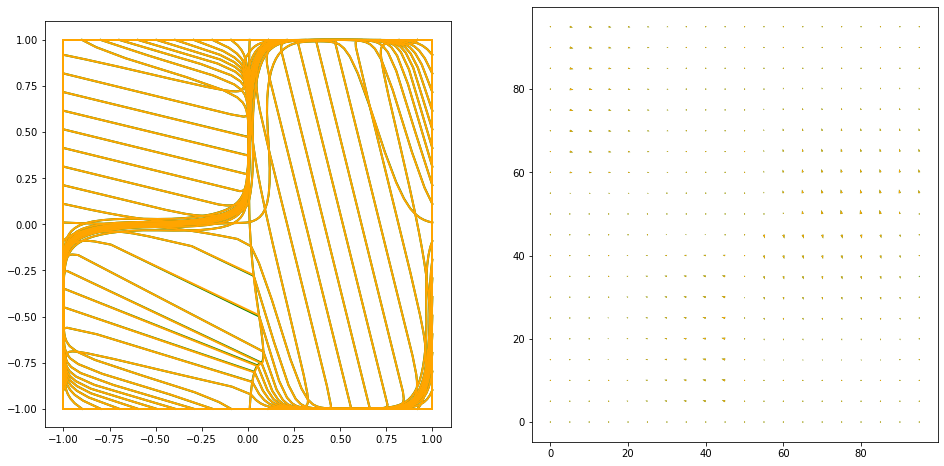

In [16]:
start = t.time()
exp_v_fast = vff.FieldIntegrator(method='fast_exp',save=False,dx_convention=dx_convention)(v.clone(),forward=False,verbose = True)
end = t.time()
print('fast exp executed in ',end - start,' s')


start = t.time()
exp_v_slow = vff.FieldIntegrator(method='slow_exp',save=False,dx_convention=dx_convention)(v.clone(),forward=False,verbose = True)
end = t.time()
print('slow exp executed in ',end - start,' s')

fig,(ax1,ax2) = plt.subplots(1,2)
# dummy_fig,d_ax = plt.subplots()
tb.gridDef_plot(exp_v_fast,ax=ax1,step=5,color='green',check_diffeo=False)
tb.quiver_plot(exp_v_fast-id_grid, ax=ax2,step =5,color='green')

tb.gridDef_plot(exp_v_slow,ax=ax1,step=5,color='orange')
tb.quiver_plot(exp_v_slow-id_grid, ax=ax2,step =5,color='orange')



# ax1.set_title("Fast Exp")
# ax2.set_title("Slow Exp")
ax1.set_aspect('equal')
fig.show()

print('norm 1 of the difference given by the two method = ',(torch.abs(exp_v_fast - exp_v_slow)).mean())

The two methods are close, but don't match perfectly (faire une étude de combien et determiner les parametres
qui sfo


# Temporal

Let's first construct a temporal vector field

/tmp/ipykernel_73132/1809357848.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v[t] = 7*tb.im2grid(torch.tensor(mbs.field2D_bspline(cm[t],n_pts,degree))[None])
/tmp/ipykernel_73132/1809357848.py:32: DeprecationWarning: Call to deprecated function gridDef_plot (Please specify the dimension by using gridDef_plot_2d ot gridDef_plot_3d).
  tb.gridDef_plot(v[t][None],add_grid=True,step=10,ax=ax[t],color='green')
/tmp/ipykernel_73132/1809357848.py:32: DeprecationWarning: Call to deprecated function gridDef_plot (Please specify the dimension by using gridDef_plot_2d ot gridDef_plot_3d).
  tb.gridDef_plot(v[t][None],add_grid=True,step=10,ax=ax[t],color='green')
/tmp/ipykernel_73132/1809357848.py:32: DeprecationWarning: Call to deprecated function gridDef_plot (Please specify the dimension by using gridDef_plot_2d ot gridDef_plot_3d).
  tb

torch.Size([5, 200, 200, 2])


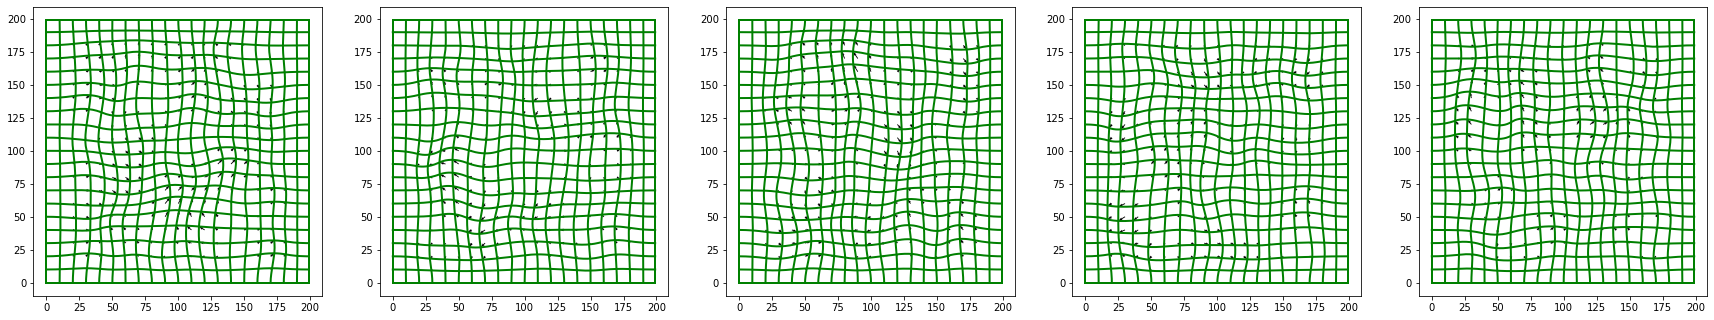

In [17]:
import torch
from torch.nn.functional import grid_sample
from math import log,ceil,pi
import matplotlib.pyplot as plt

import my_torchbox as tb
import vector_field_to_flow as vff

dx_convention = 'pixel'
Tau,H,W = (10,200,200)
id_grid = tb.make_regular_grid((1,H,W,2),dx_convention=dx_convention)

fastexp_integrator = vff.FieldIntegrator(method='fast_exp',save=False,dx_convention=dx_convention)

T,p,q = 5,12,12
cm = torch.rand((T,2,p,q))*2-1
cm[:,:,:2,:] = 0
cm[:,:,:,:2] = 0
cm[:,:,-2:,:] = 0
cm[:,:,:,-2:] = 0

v = torch.zeros(T,H,W,2)
n_pts,degree = (H,W), (2,3)
for t in range(T):
    v[t] = 7*tb.im2grid(torch.tensor(mbs.field2D_bspline(cm[t],n_pts,degree))[None])
print(v.shape)

plt.rcParams['figure.figsize'] = [30,10]
fig,ax = plt.subplots(1,T)
for t in range(T):
    tb.quiver_plot(v[t][None] ,step=10,ax=ax[t])
    tb.gridDef_plot(v[t][None],add_grid=True,step=10,ax=ax[t],color='green')


Now we can test the

/tmp/ipykernel_73132/3450105082.py:11: DeprecationWarning: Call to deprecated function gridDef_plot (Please specify the dimension by using gridDef_plot_2d ot gridDef_plot_3d).
  tb.gridDef_plot(integrated,
/tmp/ipykernel_73132/3450105082.py:19: DeprecationWarning: Call to deprecated function gridDef_plot (Please specify the dimension by using gridDef_plot_2d ot gridDef_plot_3d).
  tb.gridDef_plot(rev_integrated,add_grid=False,step=10,ax=ax[1],color='green')
/tmp/ipykernel_73132/3450105082.py:22: DeprecationWarning: Call to deprecated function gridDef_plot (Please specify the dimension by using gridDef_plot_2d ot gridDef_plot_3d).
  tb.gridDef_plot(int_on_rev_int +rev_integrated ,add_grid=False,step=10,ax=ax[2],color='green')


<AxesSubplot:>

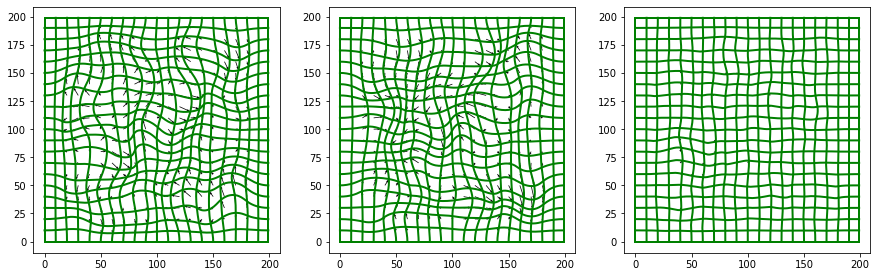

In [18]:
temporal_integrator = vff.FieldIntegrator(method='temporal',save=False,dx_convention=dx_convention)
# forward temporal integration
integrated = temporal_integrator(v,forward=True)
# backward temporal integration
rev_integrated = temporal_integrator(v,forward = False)

int_on_rev_int = tb.compose_fields(integrated-id_grid,rev_integrated,dx_convention=dx_convention)

fig,ax = plt.subplots(1,3,figsize=(15,5))
tb.quiver_plot(integrated - id_grid ,step=10,ax=ax[0],dx_convention=dx_convention)
tb.gridDef_plot(integrated,
                add_grid=False,
                step=10,
                ax=ax[0],
                color='green',
                dx_convention=dx_convention)

tb.quiver_plot(rev_integrated - id_grid,step=10,ax=ax[1])
tb.gridDef_plot(rev_integrated,add_grid=False,step=10,ax=ax[1],color='green')

tb.quiver_plot(int_on_rev_int +rev_integrated  - id_grid  ,step=10,ax=ax[2])
tb.gridDef_plot(int_on_rev_int +rev_integrated ,add_grid=False,step=10,ax=ax[2],color='green')

/home/turtlefox/anaconda3/envs/gliomorph_env/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


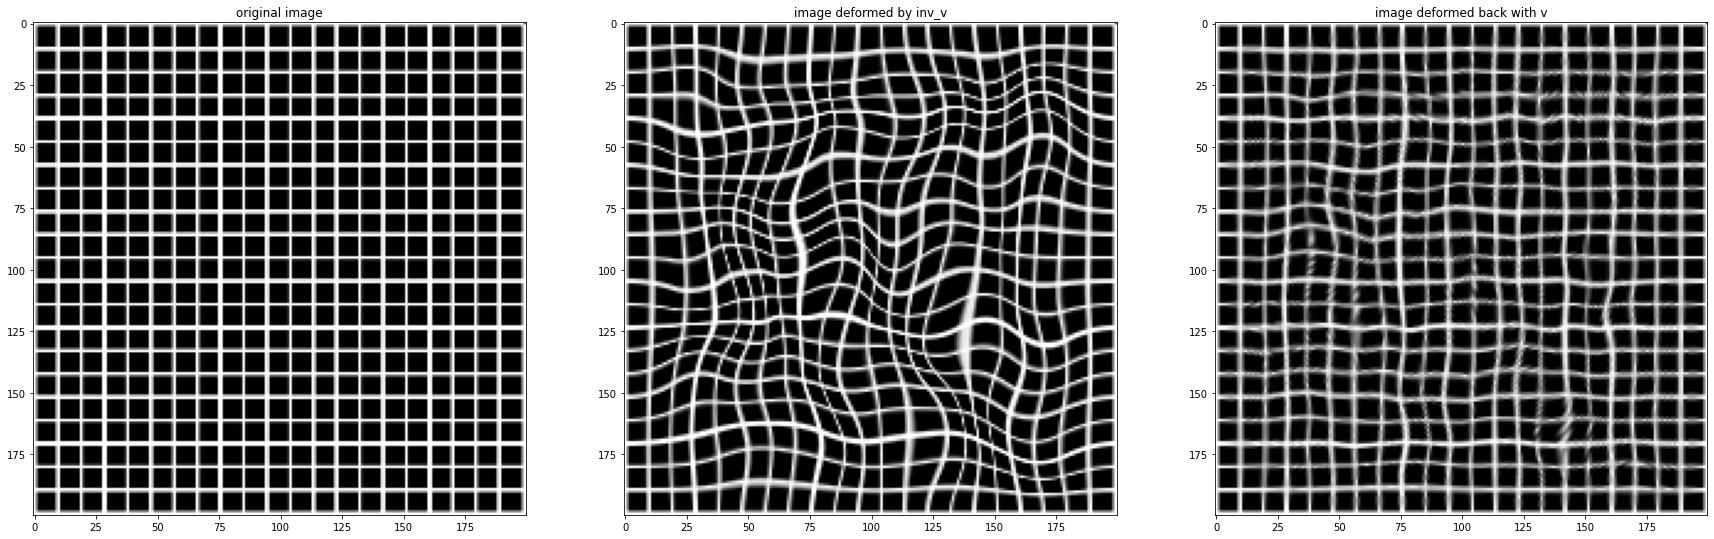

In [19]:
I = tb.reg_open('grid',size=(H,W))
I_v = tb.imgDeform(I,integrated,dx_convention=dx_convention)
# I_v = grid_sample(I,exp_v)
I_v_mv = tb.imgDeform(I_v,rev_integrated,dx_convention=dx_convention)

plt.rcParams['figure.figsize'] = [30,10]
fig, axes = plt.subplots(1,3)
axes[0].set_title('original image')
axes[0].imshow(I[0,0,:,:],cmap='gray')

axes[1].set_title('image deformed by inv_v')
axes[1].imshow(I_v[0,0,:,:],cmap='gray')

axes[2].set_title('image deformed back with v')
axes[2].imshow(I_v_mv[0,0,:,:],cmap='gray')
plt.show()